In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from skimage import exposure, io, transform
import matplotlib.pyplot as plt


model = keras.models.load_model('./model/trafficsignnet.model')

In [36]:
def returnRedness(img):
	yuv=cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
	y,u,v=cv2.split(yuv)
	return v

def threshold(img,T=150):
	_,img=cv2.threshold(img,T,255,cv2.THRESH_BINARY)
	return img 

def findContour(img):
	contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
	return contours

def findBiggestContour(contours):
	m = 0
	c = [cv2.contourArea(i) for i in contours]
	return contours[c.index(max(c))]

def boundaryBox(img,contours):
	x,y,w,h=cv2.boundingRect(contours)
	img=cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
	sign=img[y:(y+h) , x:(x+w)]
	return img,sign

def plot_img(image, title="", cmap='viridis'):
	plt.imshow(image, cmap=cmap)
	plt.title(title)
	plt.axis('off')
	plt.show()

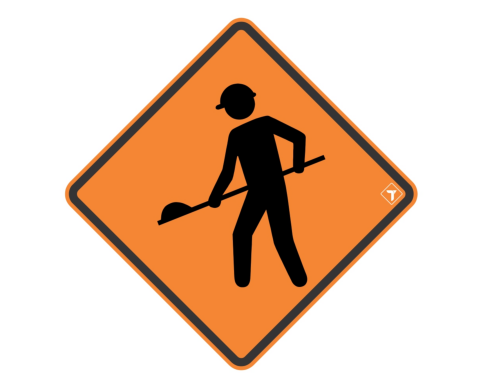

In [41]:
image = io.imread("./test/obras.png")

plot_img(image)

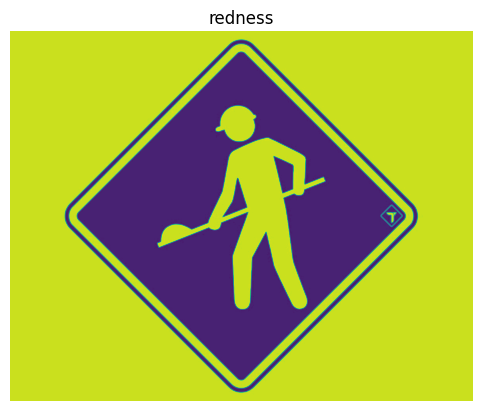

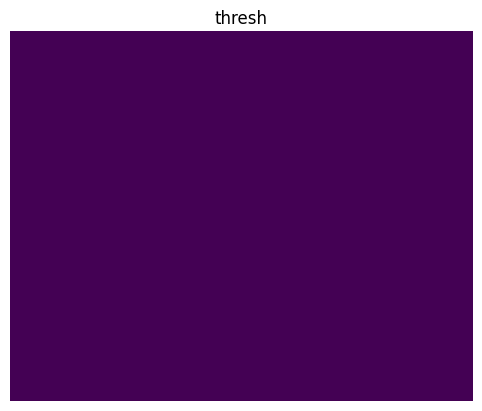

In [42]:
redness = returnRedness(image)
thresh = threshold(redness) 	

plot_img(redness, "redness")
plot_img(thresh, "thresh")

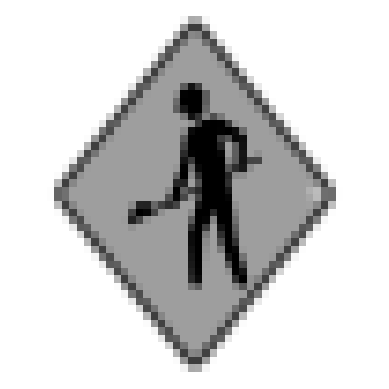

In [57]:
labelToText = {
	0: "Limite de Velocidade (30km/h)",
	1: "Pare",
	2: "Não entre",
	3: "Estrada em obras",
	4: "Pedestres",
	5: "Crianças",
	6: "Bicicletas",
	7: "Animais selvagens",
	8: "Siga em frente",
	9: "Mantenha a direita",
	10: "Mantenha a esquerda"
}

def preprocessingImageToClassifier(image=None,imageSize=50,mu=89.77428691773054,std=70.85156431910688):
	image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
	image = cv2.resize(image,(imageSize,imageSize), interpolation=cv2.INTER_AREA)
	#image = np.expand_dims(image, axis=-1)
	image = (image - mu) / std
	#image = image.reshape(1,imageSize,imageSize,1)
	return image


proc_img = preprocessingImageToClassifier(image)

plot_img(proc_img, cmap='gray')

In [ ]:
def predict4(sign):
	extr_img=preprocessingImageToClassifier(sign,imageSize=28)
	return np.argmax(model.predict(extr_img))